# Iris in R


## Content
1. Import libraries and prepare data
   * Import packages
   * Load data
   * Missing values
   * Divide into train/validation
2. Data: Understanding and visualization
   * Pairplot
   * Box plot
   * Correlation matrix
3. Feature analysis
   * Decision tree
   * RFECV
4. Modeling
   * Random forest using all features
   * Random forest and SVM using sepal length and width
   * Random forest and SVM using petal length and width
   
# 1. Preparation of data


In [2]:
library(ggplot2)
library(GGally)
library(lattice)
library(caret)
library(randomForest)
library(cowplot)
library(tree)
library(e1071)
library(dplyr)

## 1.1 Loading data
#### We start by loading the data we want to analyze

In [3]:
# Load data
data(iris)
dataset <- iris 

# View data
head(dataset)

# Look at the different classes we have
cat('Classes in dataset: ')
cat(crayon::bold(levels(dataset$Species)), sep = ' & ')

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


Classes in dataset: setosa & versicolor & virginica

## 1.2 Missing values
#### We now check if there are any missing values. There are multiple ways to deal with missing values, such as removing the rows, however, this might not always be the smartest. The reason for this is that a dataset might have a lot of features and due to reasons (if the data is old, not recorded and so on) there might be some missing values in some features here and there, but removing a row with, for example, 20 features where one of them have a missing value is not good, as the 19 features might contain valuable information. 

#### In this dataset, there are no missing values. If we try to remove any row with a missing value, we see that the dimension of the dataset is the same before and after.

In [4]:
cat('Dimension of dataset:', dim(dataset)[1], 'x', dim(dataset)[2], '\n')
dataset <- na.omit(dataset)
cat('Dimension of dataset after removing missing values:', dim(dataset)[1], 'x', dim(dataset)[2])

Dimension of dataset: 150 x 5 
Dimension of dataset after removing missing values: 150 x 5

## 1.3 Split data into train/validation

#### We split the dataset into a training set and a validation set. We use a ratio of 0.70.

In [5]:
# Variable of interest
Y = dataset$Species
Y_loc = 5 # location of output response 
X_loc = 1:4 # location of features used for prediction

set.seed(1)
validation_index <- createDataPartition(Y, p = 0.70, list = F)
validation <- dataset[-validation_index,]
dataset <- dataset[validation_index,]

# 2. Visualization of dataset 


## 2.1 Pairplot

#### From the pairplot, we observe that setosa can be easily separated from the two other classes, meanwhile versicolor and virginica are not as easily separated.

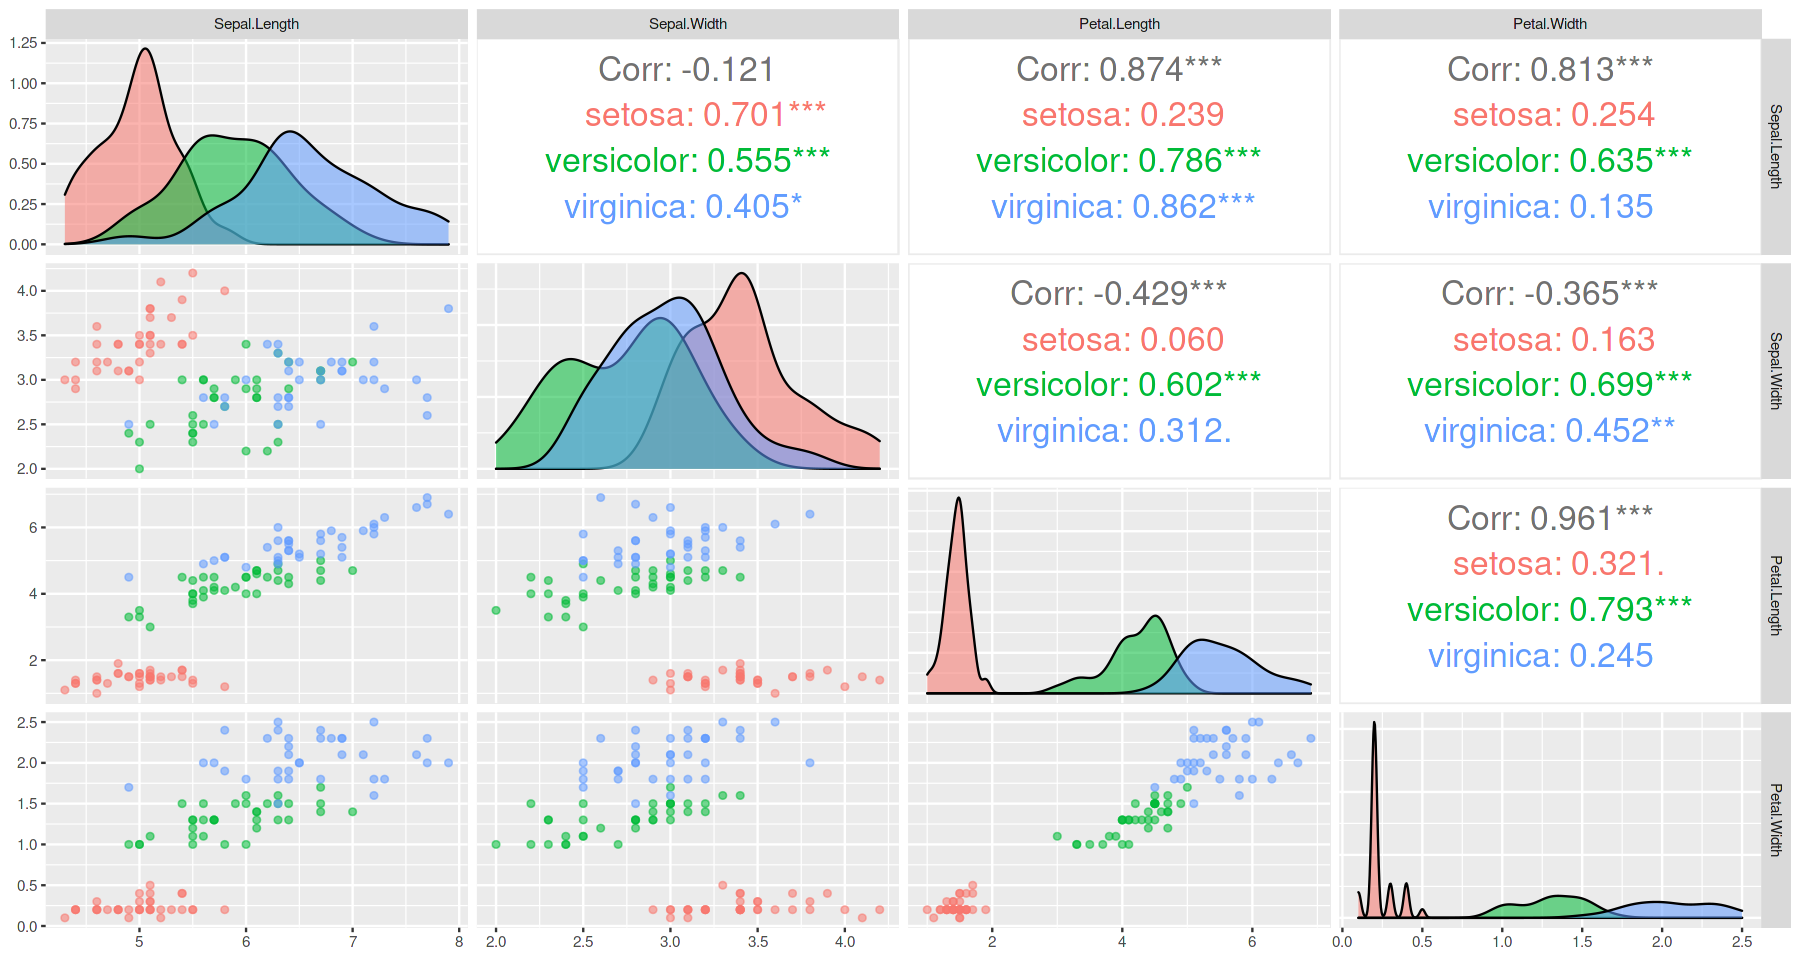

In [6]:
options(repr.plot.width=15, repr.plot.height=8)
ggpairs(dataset,
        columns = X_loc,
        aes(color = Species,
            alpha = 0.5),
        upper = list(continuous = wrap("cor", size = 7)))

## 2.2 Box plot

#### From the blox plot of sepal length and sepal width found below, we don't see any significant patterns that can separate the classes very easily. However, if we look at petal length and petal width (PLW), we see that they follow a stair-case pattern, where setosa has the smallest PLW, veriscolor has medium PLW, and virgincia has the largest PLW. There is also very little overlap between the classes, and setosa can be easily separated from the two other classes by only considering PLW. 

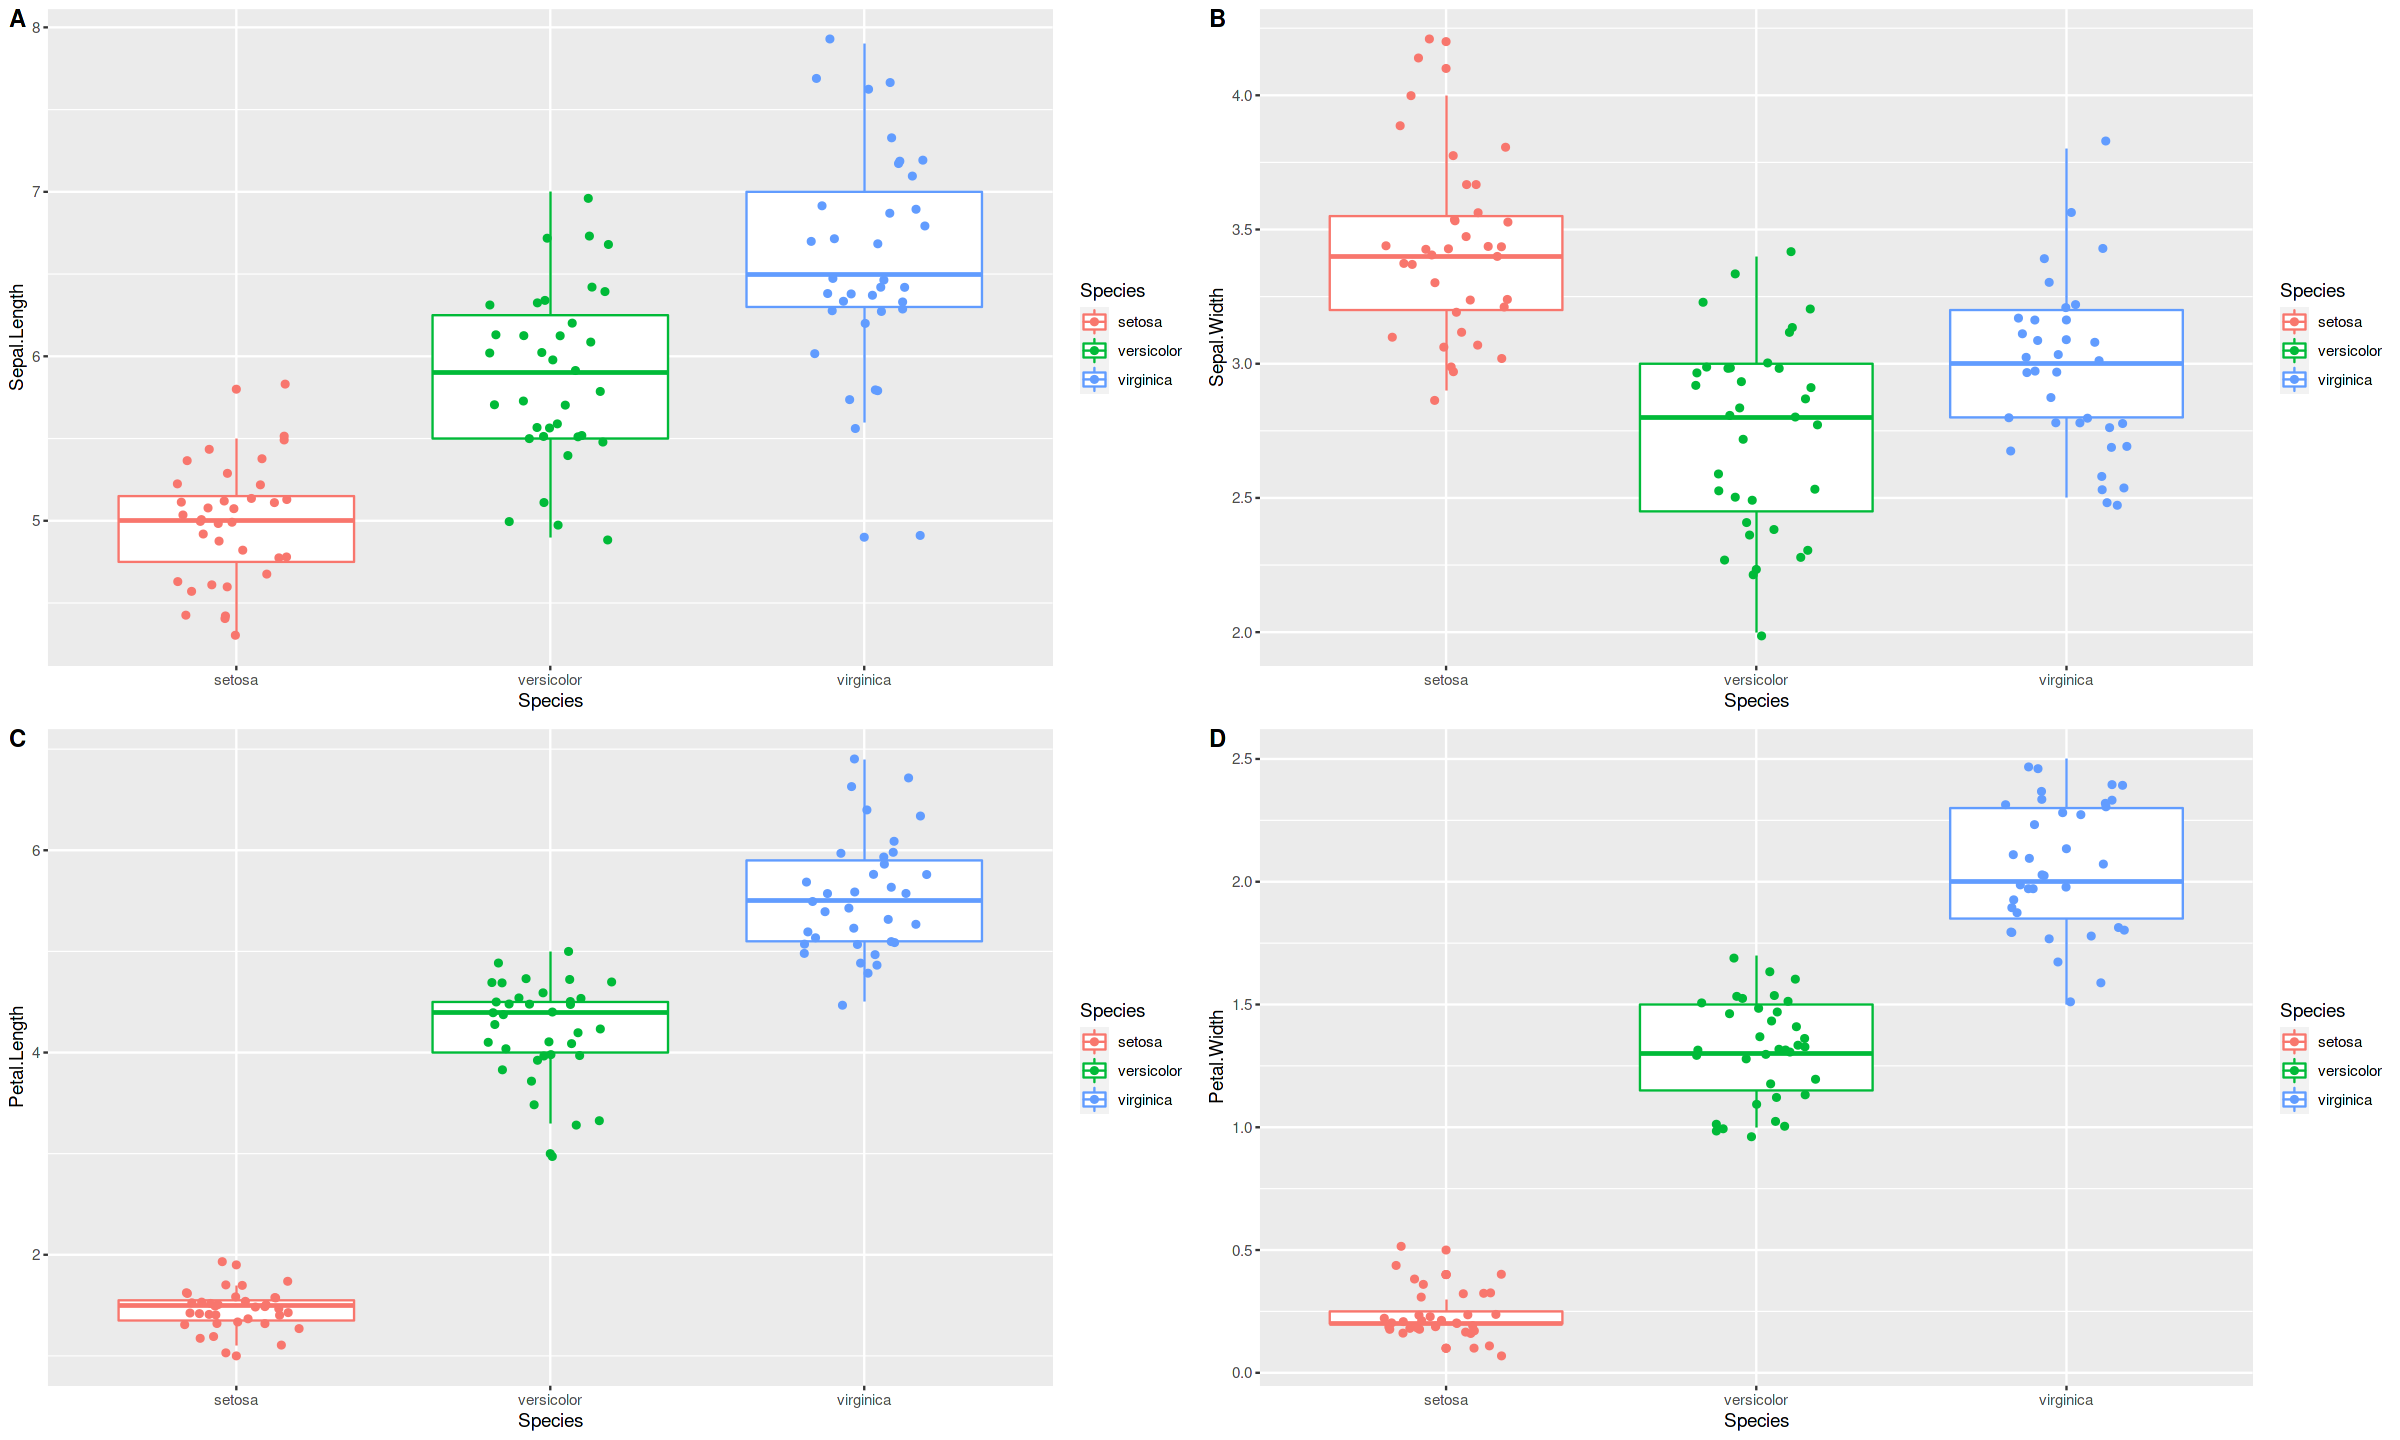

In [7]:
options(repr.plot.width=20, repr.plot.height=12)
Sepal1 <- ggplot(dataset) +
  aes(x = Species, y = Sepal.Length, color = Species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

Sepal2 <- ggplot(dataset) +
  aes(x = Species, y = Sepal.Width, color = Species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

Petalplot1 <- ggplot(dataset) +
  aes(x = Species, y = Petal.Length, color = Species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

Petalplot2 <- ggplot(dataset) +
  aes(x = Species, y = Petal.Width, color = Species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot_grid(Sepal1, Sepal2, Petalplot1, Petalplot2, labels = "AUTO")

## 2.3 Correlation matrix

In [8]:
dataset %>%
    select_if(is.numeric) %>%
    cor()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.0000000,-0.1208765,0.8744806,0.8129227
Sepal.Width,-0.1208765,1.0000000,-0.4285856,-0.3648924
Petal.Length,0.8744806,-0.4285856,1.0000000,0.9611605
Petal.Width,0.8129227,-0.3648924,0.9611605,1.0000000


# 3. Feature analysis

#### We now use RFECV and a decision tree to investigate which of our features are important. 


## 3.1 Decision tree
#### From the decision tree, we see that only the features petal length and petal width are chosen. The decision tree found that sepal length and sepal width were not important. This matches with what we found in Section 2.1 and 2.2. We also see that we only need petal length to know setosa.

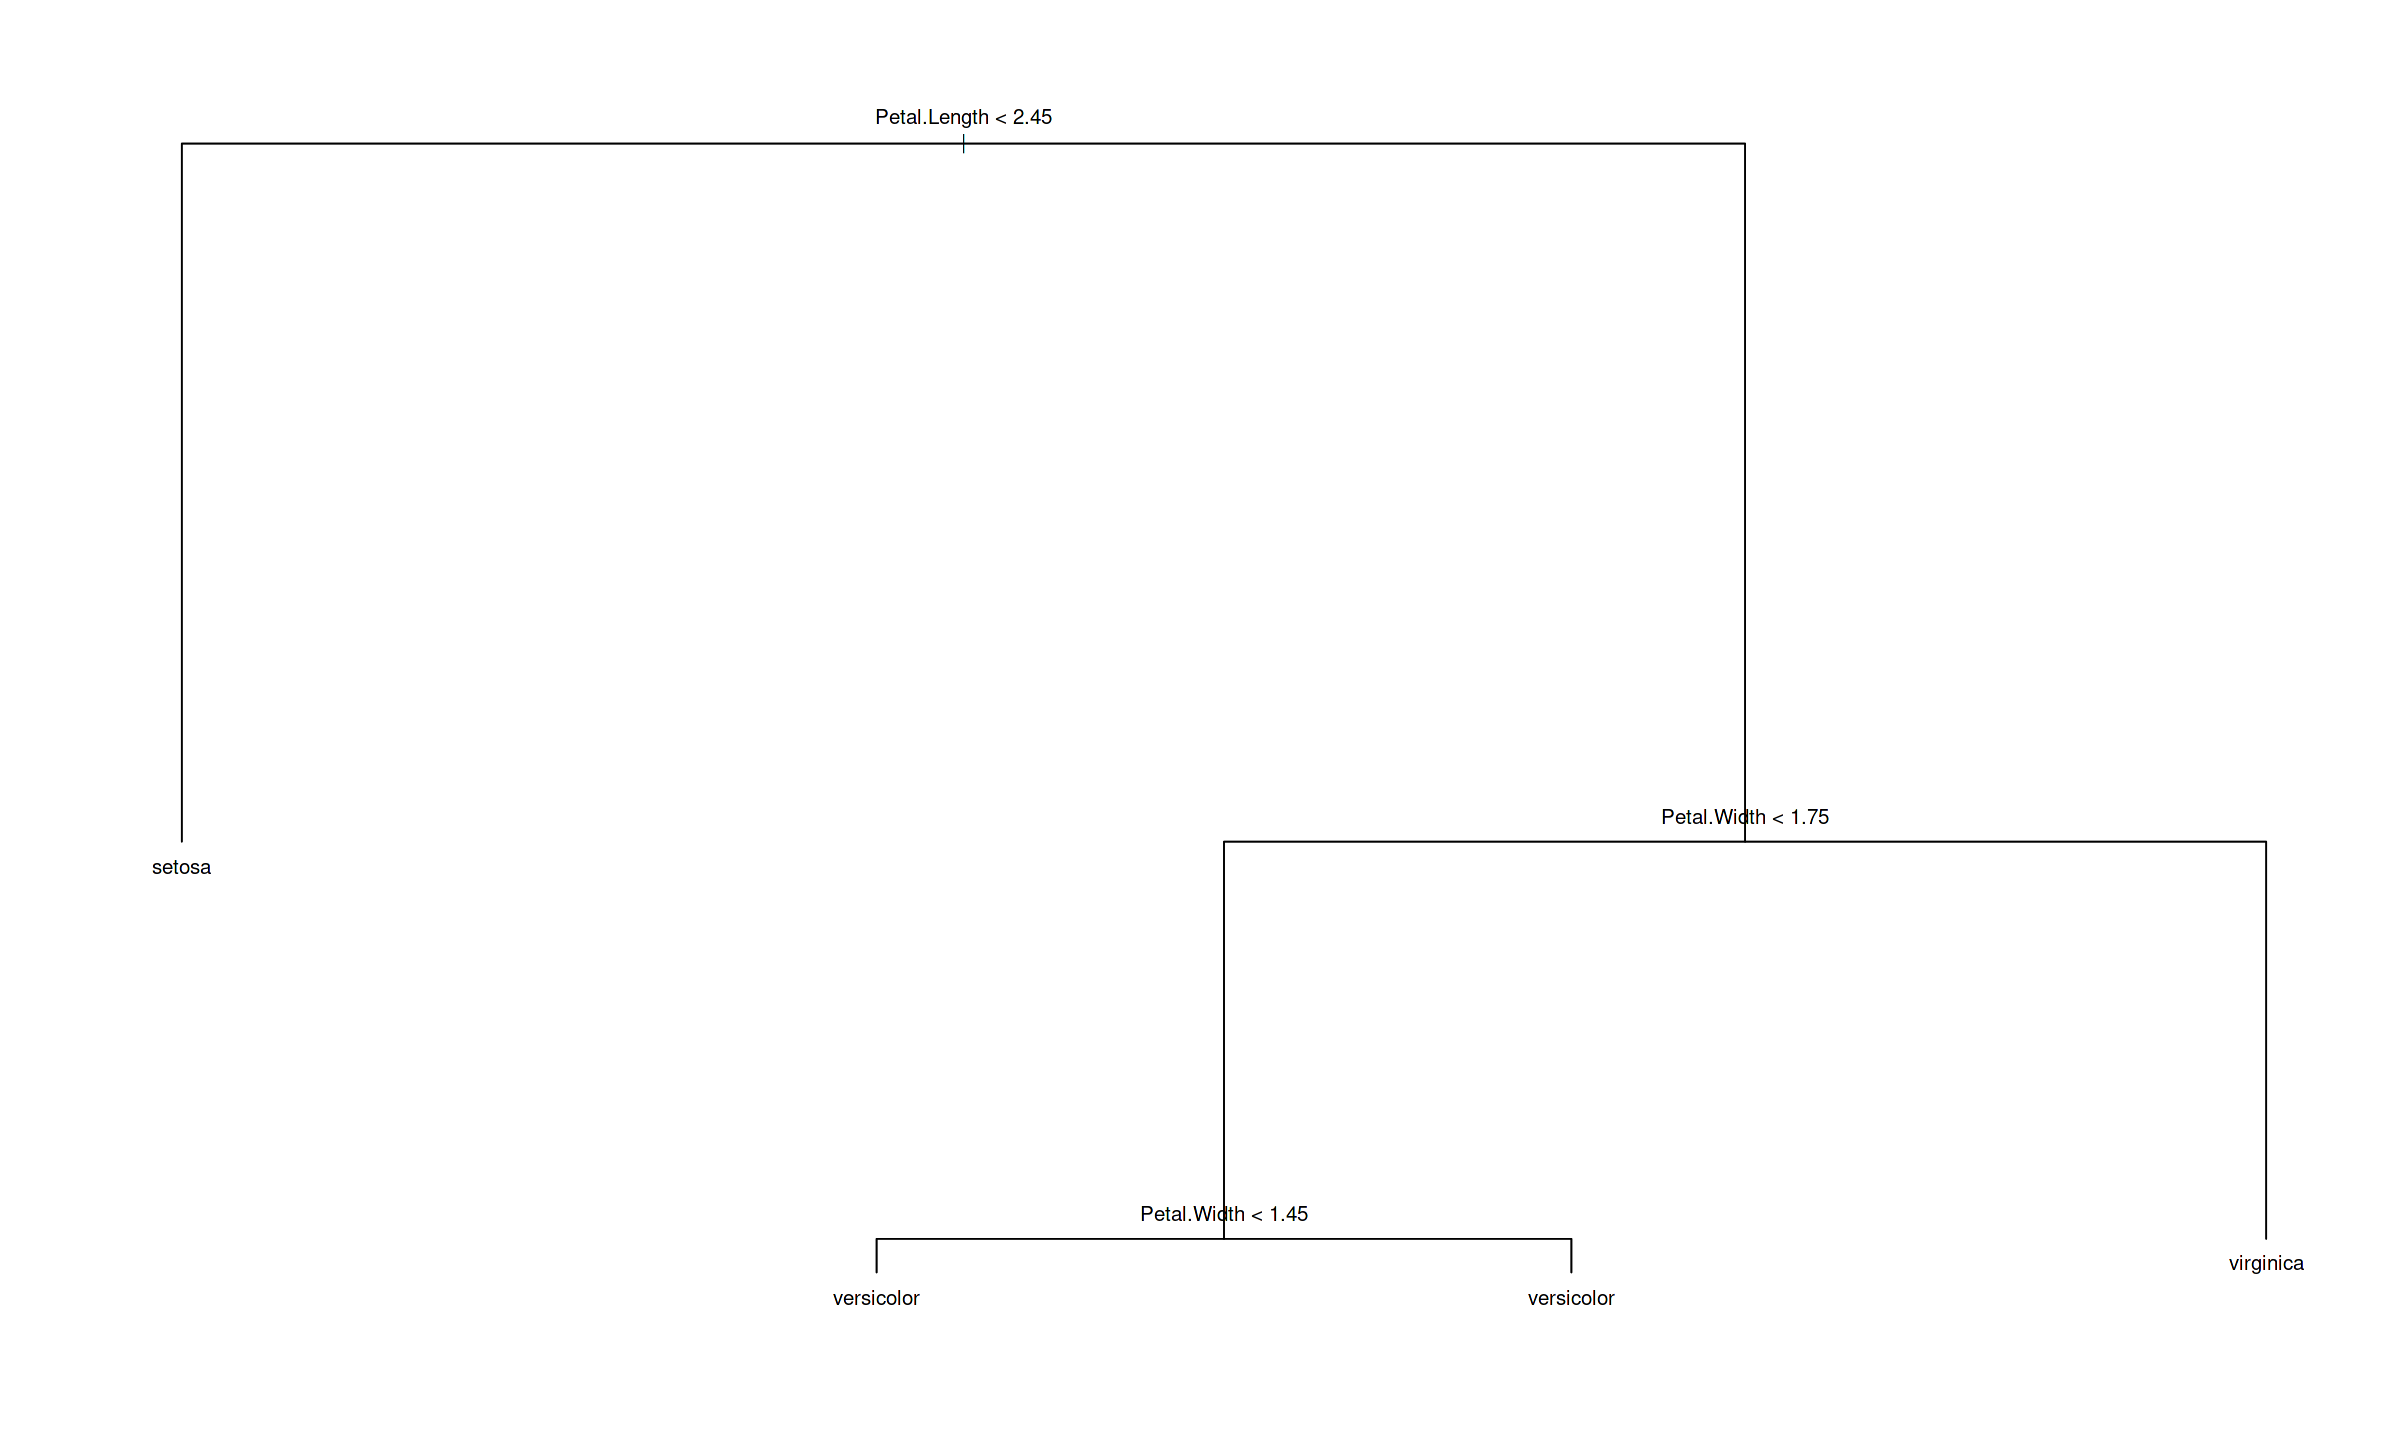

In [9]:
decision_tree <- tree(Species ~ ., data = dataset)

plot(decision_tree)
text(decision_tree, pretty = 0)

## 3.2 RFECV
#### From the RFECV, we see that sepal width and sepal length are less important. This matches well with our decision tree plot.

In [10]:
control <- trainControl(method="repeatedcv", number=10, repeats=3)

model <- train(Species ~., data=dataset, method="rf", preProcess="scale", trControl=control)

importance <- varImp(model, scale=FALSE)
print(importance)

rf variable importance

             Overall
Petal.Length 32.1356
Petal.Width  30.1305
Sepal.Length  6.0207
Sepal.Width   0.9961


# 4. Modelling

## 4.1. Full model

#### Decision trees easily overfit, so we do not use it as one our models. Instead, we use random forest.

In [11]:
classifier <- randomForest(Species ~., data = dataset, importance = T) 
predicted_table <- predict(classifier, validation[,X_loc])
table(observed = validation[,Y_loc], predicted = predicted_table)

            predicted
observed     setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         13         2
  virginica       0          1        14

## 4.2 Only sepal length and width

#### We see that it manages to separate setosa without any problem, which is as expected when we looked at our pairplots. When it comes to the two other classes, we see that it has a much bigger problem separating them, as they share a lot of the same SLW. 

#### To investigate this further, we use SVM with radial kernel.

            predicted
observed     setosa versicolor virginica
  setosa         14          1         0
  versicolor      0          8         7
  virginica       0          5        10

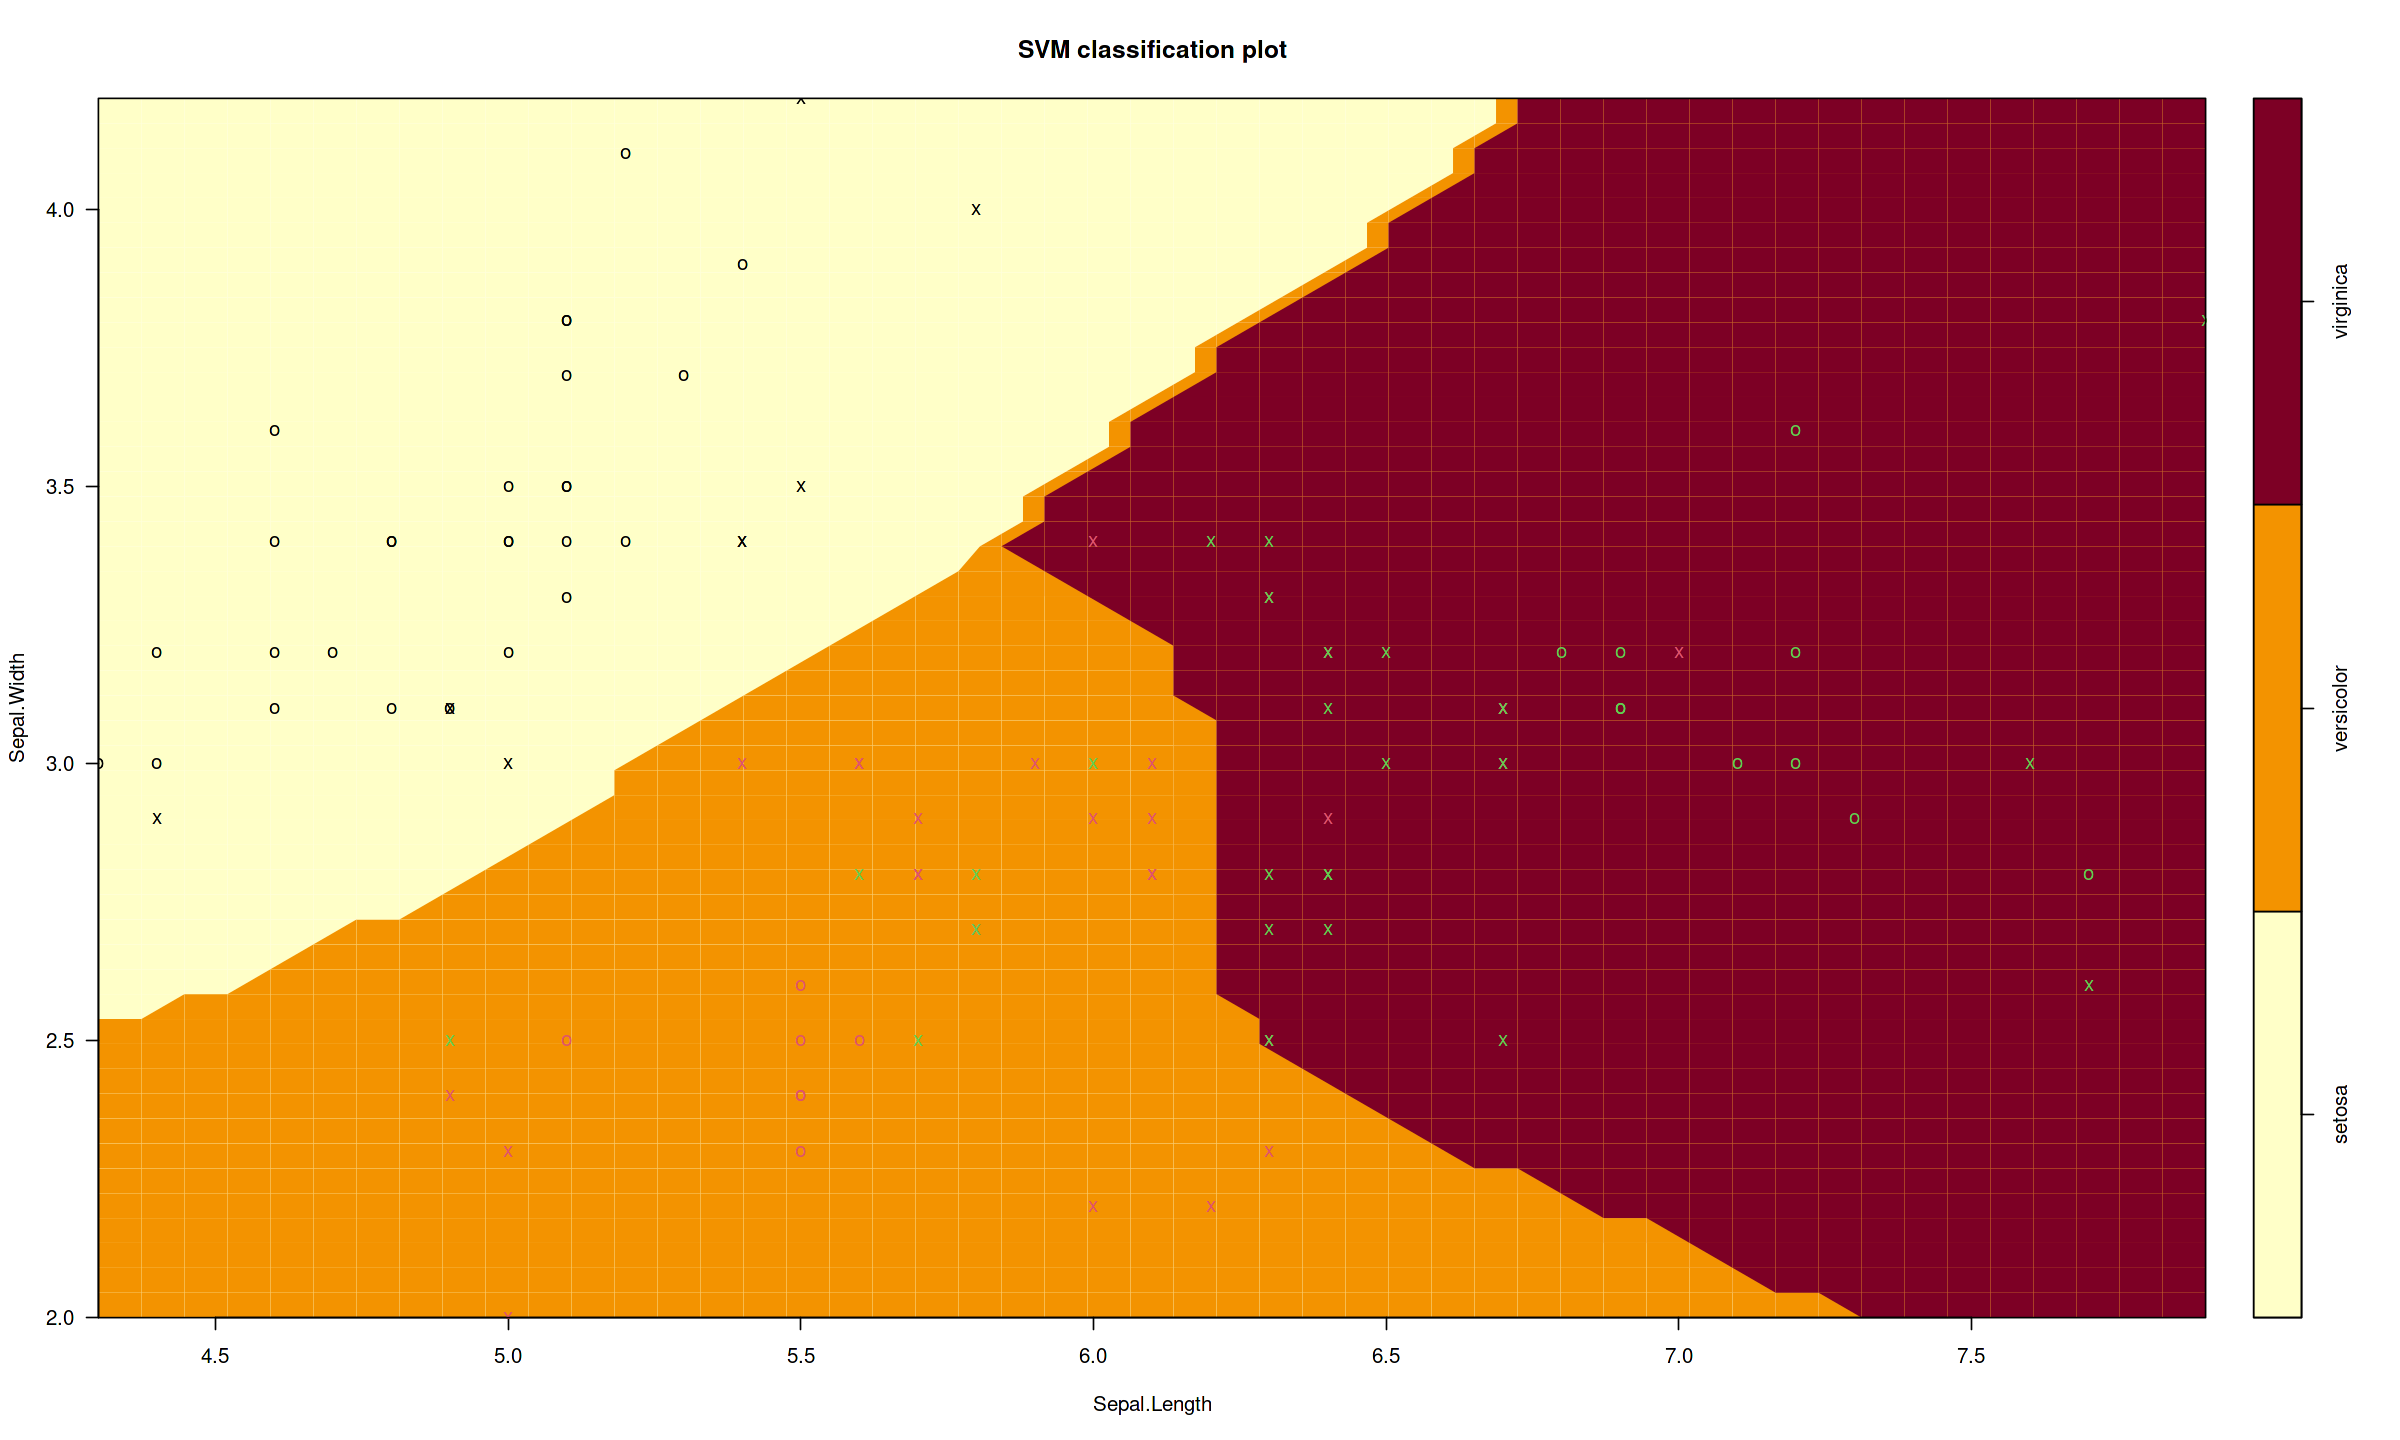

In [12]:
vars = c(1,2,5)
vars2 = c(1,2)
classifier <- randomForest(Species ~., data = dataset[vars], importance = T) 
predicted_table <- predict(classifier, validation[,vars2])
table(observed = validation[,Y_loc], predicted = predicted_table)


svm_model <- svm(Species ~ ., data=dataset[vars], kernel="radial")
plot(svm_model, data=dataset[vars], Sepal.Width~Sepal.Length)

## 4.3 Only petal length and width
#### If we only use petal length and width features, we observe that we get the same performance on the test set as we did with the full model.

            predicted
observed     setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         13         2
  virginica       0          1        14

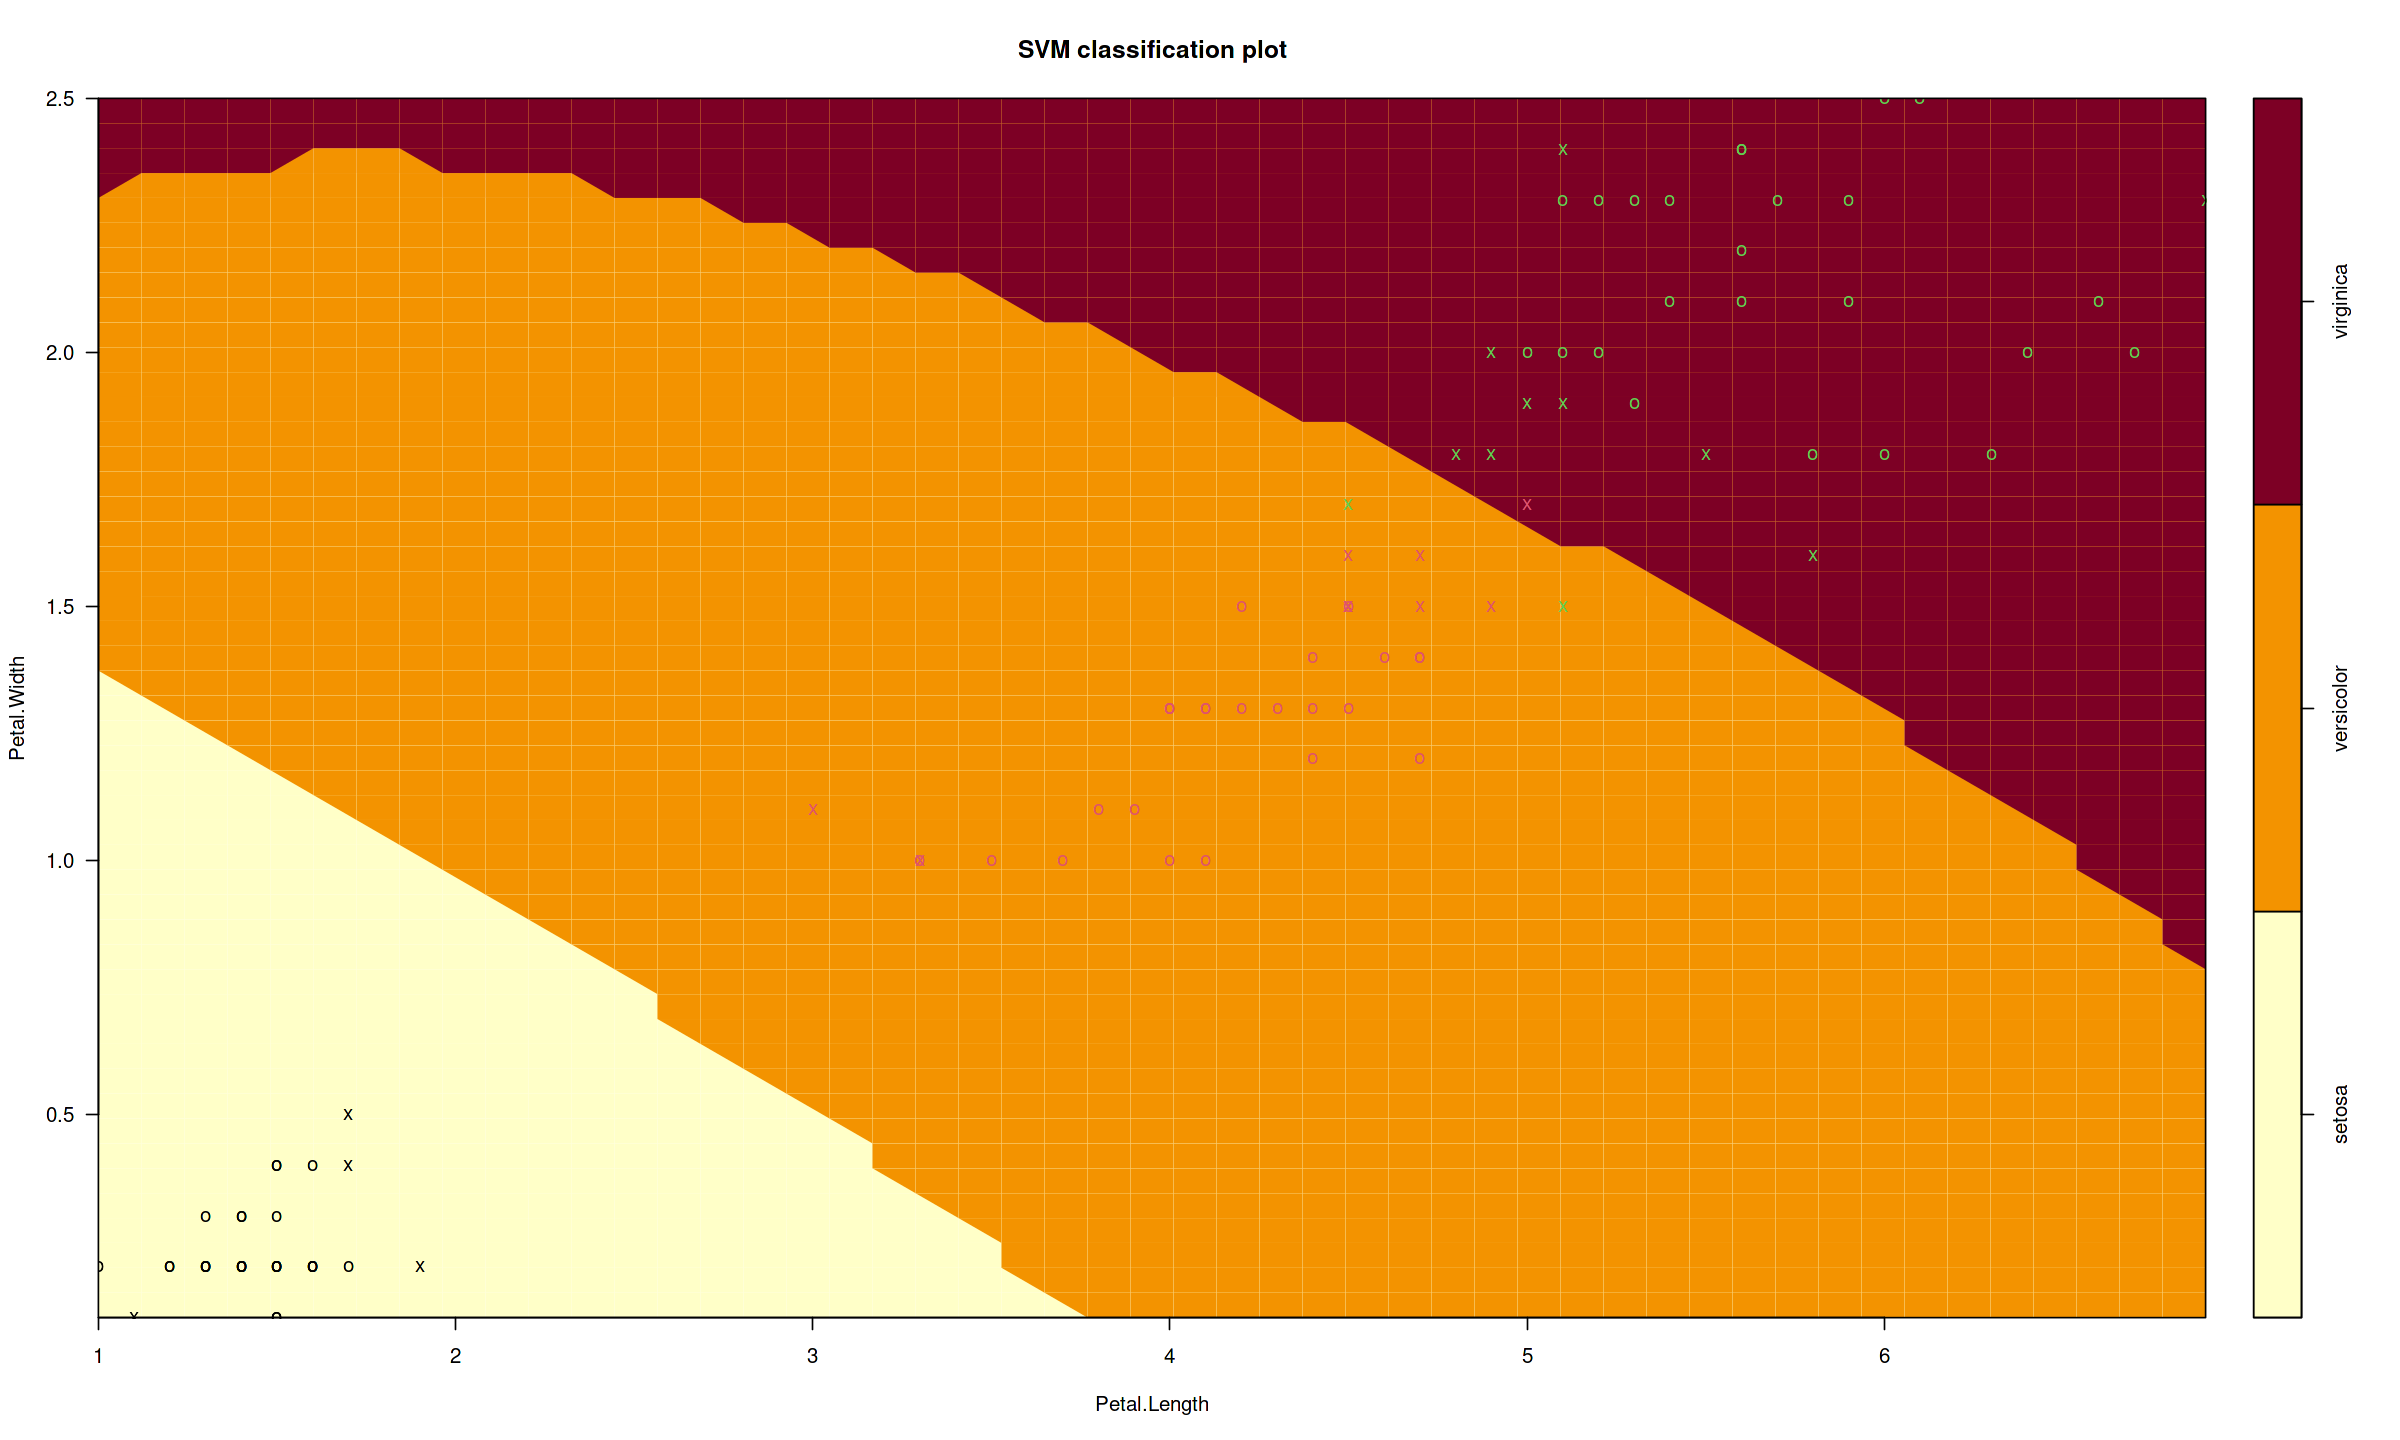

In [13]:
vars = c(3,4,5)
classifier <- randomForest(Species ~., data = dataset[vars], importance = T) 

predicted_table <- predict(classifier, validation[,3:4])
table(observed = validation[,Y_loc], predicted = predicted_table)

svm_model <- svm(Species ~ ., data=dataset[vars], kernel="radial")
plot(svm_model, data=dataset[vars], Petal.Width~Petal.Length)